# 🧩 Mini-Lab: Multi-Head Attention

**Module 2: Understanding Large Language Models** | **Duration: ~45 min** | **Type: Mini-Lab (Brick)**

---

## Learning Objectives

By the end of this mini-lab, you will be able to:

1. **Understand** why we use multiple attention heads instead of one
2. **Visualize** how different heads capture different patterns
3. **Implement** a simple multi-head attention mechanism from scratch

## Target Concepts

| Concept | Description |
|---------|-------------|
| Multi-Head Attention | Multiple parallel attention mechanisms focusing on different aspects of the input |

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

def md(text):
    """Display text as rendered markdown."""
    display(Markdown(text))

np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)
print("✓ Setup complete")

✓ Setup complete


## 2. Why Multiple Heads?

A single attention mechanism can only learn one type of relationship. **Multi-head attention** runs multiple attention mechanisms in parallel, each learning different patterns:

- **Head 1** might focus on syntactic relationships (subject-verb)
- **Head 2** might capture positional patterns (nearby words)
- **Head 3** might track semantic similarity

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

where each $\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$

In [2]:
def softmax(x, axis=-1):
    """Stable softmax implementation."""
    x = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def single_head_attention(Q, K, V):
    """Compute scaled dot-product attention for one head."""
    d_k = Q.shape[-1]
    scores = (Q @ K.T) / np.sqrt(d_k)
    weights = softmax(scores, axis=-1)
    output = weights @ V
    return output, weights

print("✓ Single-head attention defined")

✓ Single-head attention defined


## 3. Implementing Multi-Head Attention

In [9]:
class MultiHeadAttention:
    """Simple multi-head attention implementation."""
    
    def __init__(self, d_model, num_heads, use_distinct_patterns=False):
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        self.use_distinct_patterns = use_distinct_patterns
        
        # Initialize projection weights with DIFFERENT seeds for each head
        # This simulates heads learning different patterns through training
        self.W_Q = []
        self.W_K = []
        self.W_V = []
        
        for h in range(num_heads):
            np.random.seed(h * 100 + 1)  # Different seed per head
            self.W_Q.append(np.random.randn(d_model, self.d_k))
            np.random.seed(h * 100 + 2)
            self.W_K.append(np.random.randn(d_model, self.d_k))
            np.random.seed(h * 100 + 3)
            self.W_V.append(np.random.randn(d_model, self.d_k))
        
        np.random.seed(42)
        self.W_O = np.random.randn(d_model, d_model) * 0.1
    
    def forward(self, X):
        """Forward pass through multi-head attention."""
        head_outputs = []
        head_weights = []
        
        for h in range(self.num_heads):
            # Project to Q, K, V for this head
            Q_h = X @ self.W_Q[h]
            K_h = X @ self.W_K[h]
            V_h = X @ self.W_V[h]
            
            # Compute attention for this head
            output_h, weights_h = single_head_attention(Q_h, K_h, V_h)
            
            head_outputs.append(output_h)
            head_weights.append(weights_h)
        
        # Concatenate all heads
        concat = np.concatenate(head_outputs, axis=-1)
        
        # Final projection
        output = concat @ self.W_O
        
        return output, head_weights

print("✓ MultiHeadAttention class defined")

✓ MultiHeadAttention class defined


## 4. Visualizing Multiple Heads (Random Initialization)

With randomly initialized weights (no training), heads may look similar. Let's first see the raw output, then compare with simulated trained patterns.

In [10]:
# Example sentence
tokens = ["The", "bank", "by", "the", "river", "is", "closed"]
seq_len = len(tokens)
d_model = 8  # Embedding dimension
num_heads = 4  # Number of attention heads

# Create random embeddings (in practice, from embedding layer)
X = np.random.randn(seq_len, d_model)

# Create multi-head attention
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

# Forward pass
output, all_weights = mha.forward(X)

print(f"Input shape: {X.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of heads: {len(all_weights)}")
print(f"Each head's weight shape: {all_weights[0].shape}")

Input shape: (7, 8)
Output shape: (7, 8)
Number of heads: 4
Each head's weight shape: (7, 7)


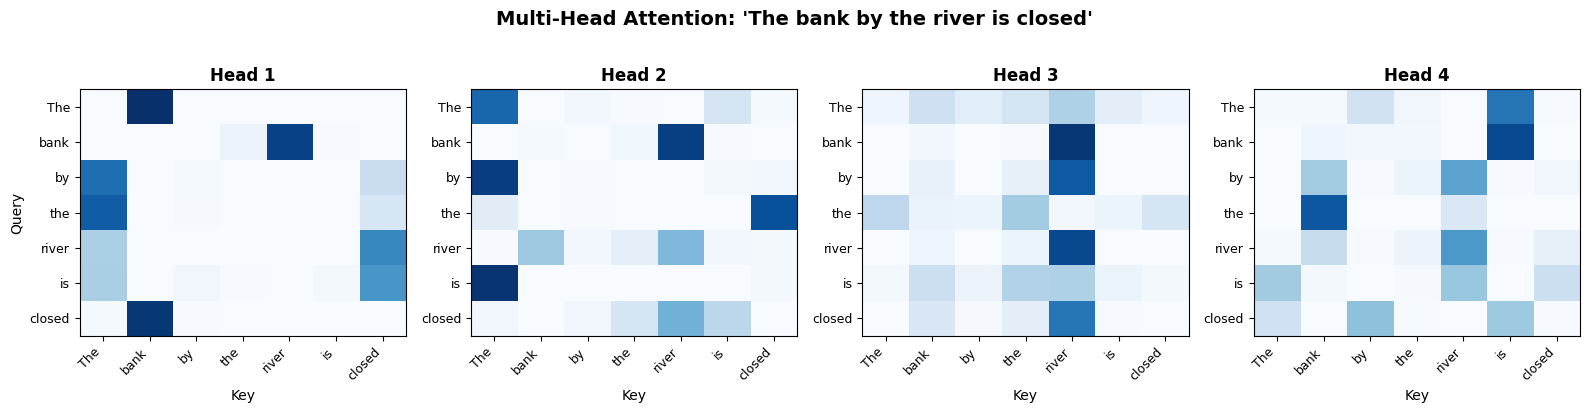

In [11]:
def plot_all_heads(weights_list, tokens, title="Multi-Head Attention"):
    """Visualize attention patterns from all heads."""
    num_heads = len(weights_list)
    fig, axes = plt.subplots(1, num_heads, figsize=(4 * num_heads, 4))
    
    if num_heads == 1:
        axes = [axes]
    
    for h, (ax, weights) in enumerate(zip(axes, weights_list)):
        im = ax.imshow(weights, cmap='Blues', aspect='auto', vmin=0, vmax=1)
        
        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))
        ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(tokens, fontsize=9)
        ax.set_title(f"Head {h + 1}", fontweight='bold')
        
        if h == 0:
            ax.set_ylabel("Query", fontsize=10)
        ax.set_xlabel("Key", fontsize=10)
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_all_heads(all_weights, tokens, "Multi-Head Attention: 'The bank by the river is closed'")

## 5. What Trained Heads Actually Learn

With random weights (no training), heads look similar. Let's simulate what **trained heads** would learn to show you the real power of multi-head attention.

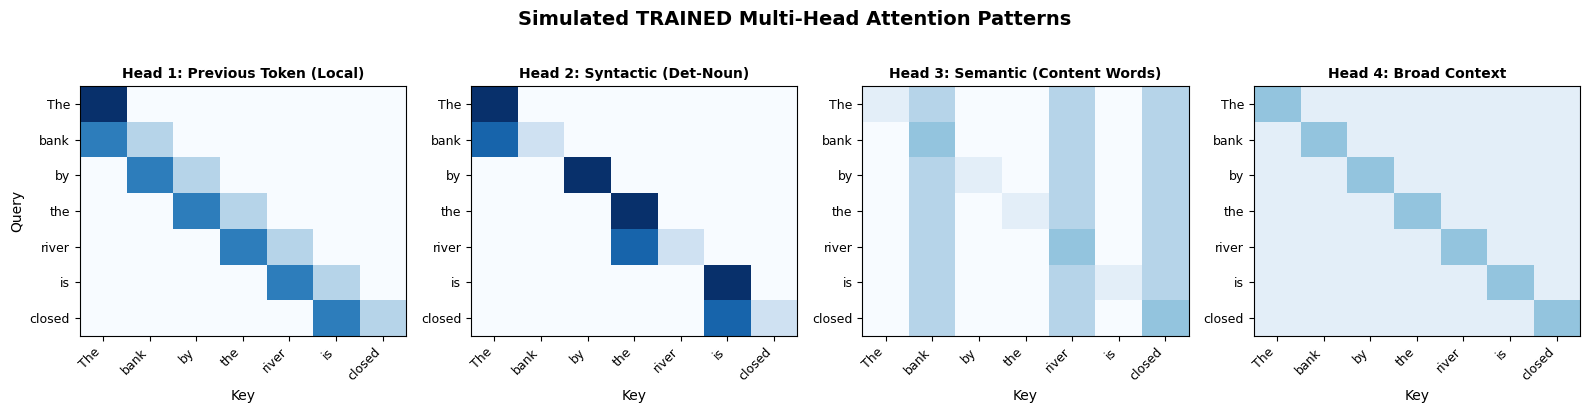


**What each head learns (simulated):**
- **Head 1 (Local)**: Each token attends to its previous token - captures sequential relationships
- **Head 2 (Syntactic)**: Nouns attend to their determiners - captures grammatical structure  
- **Head 3 (Semantic)**: All tokens attend to content words (bank, river, closed) - captures meaning
- **Head 4 (Broad)**: Distributes attention more evenly - provides global context


In [12]:
def create_simulated_trained_patterns(tokens):
    """
    Create simulated attention patterns showing what TRAINED heads learn.
    In real trained transformers, different heads specialize in different patterns.
    """
    n = len(tokens)
    trained_weights = []
    head_descriptions = []
    
    # Head 1: Positional (attend to previous token) - like a "local context" head
    h1 = np.zeros((n, n))
    for i in range(n):
        if i > 0:
            h1[i, i-1] = 0.7  # Previous token
        h1[i, i] = 0.3  # Self
    h1 = h1 / h1.sum(axis=1, keepdims=True)  # Normalize
    trained_weights.append(h1)
    head_descriptions.append("Previous Token (Local)")
    
    # Head 2: Syntactic (subject-verb, determiner-noun) 
    h2 = np.zeros((n, n))
    # "The" -> "bank", "the" -> "river", "is" -> "closed"
    h2[1, 0] = 0.8  # bank attends to The
    h2[4, 3] = 0.8  # river attends to the  
    h2[6, 5] = 0.8  # closed attends to is
    h2 = h2 + np.eye(n) * 0.2  # Add some self-attention
    h2 = h2 / h2.sum(axis=1, keepdims=True)
    trained_weights.append(h2)
    head_descriptions.append("Syntactic (Det-Noun)")
    
    # Head 3: Global/semantic (attend to content words)
    h3 = np.zeros((n, n))
    content_words = [1, 4, 6]  # bank, river, closed
    for i in range(n):
        for j in content_words:
            h3[i, j] = 0.3
    h3 = h3 + np.eye(n) * 0.1
    h3 = h3 / h3.sum(axis=1, keepdims=True)
    trained_weights.append(h3)
    head_descriptions.append("Semantic (Content Words)")
    
    # Head 4: Broad/uniform (attend more evenly)
    h4 = np.ones((n, n)) * 0.1
    h4 = h4 + np.eye(n) * 0.3  # Slight self preference
    h4 = h4 / h4.sum(axis=1, keepdims=True)
    trained_weights.append(h4)
    head_descriptions.append("Broad Context")
    
    return trained_weights, head_descriptions

# Create simulated trained patterns
trained_weights, head_labels = create_simulated_trained_patterns(tokens)

# Plot with descriptive labels
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for h, (ax, weights, label) in enumerate(zip(axes, trained_weights, head_labels)):
    im = ax.imshow(weights, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(tokens, fontsize=9)
    ax.set_title(f"Head {h + 1}: {label}", fontweight='bold', fontsize=10)
    
    if h == 0:
        ax.set_ylabel("Query", fontsize=10)
    ax.set_xlabel("Key", fontsize=10)

plt.suptitle("Simulated TRAINED Multi-Head Attention Patterns", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

md("""
**What each head learns (simulated):**
- **Head 1 (Local)**: Each token attends to its previous token - captures sequential relationships
- **Head 2 (Syntactic)**: Nouns attend to their determiners - captures grammatical structure  
- **Head 3 (Semantic)**: All tokens attend to content words (bank, river, closed) - captures meaning
- **Head 4 (Broad)**: Distributes attention more evenly - provides global context
""")

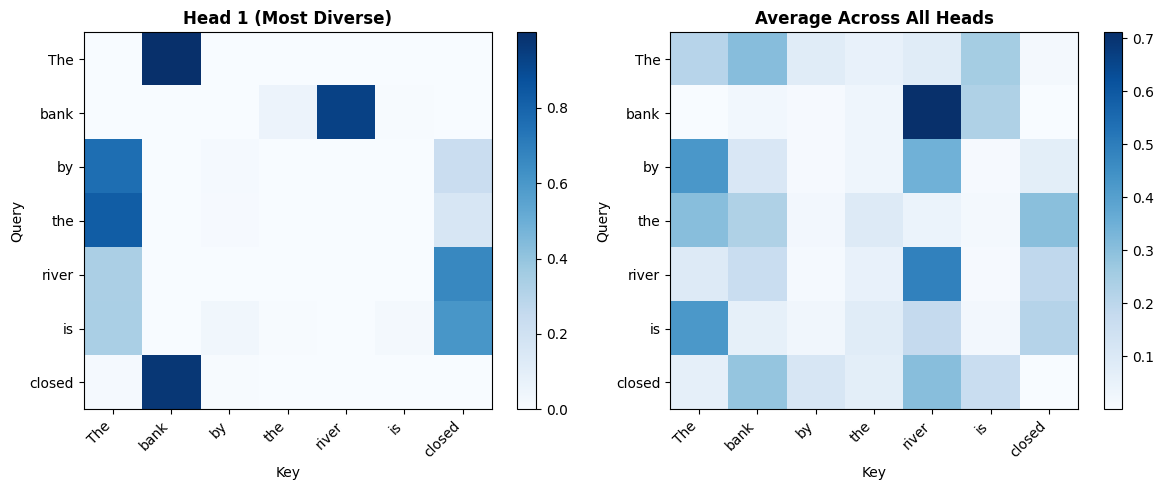

**Insight**: Individual heads show specialized patterns, while the average is more uniform.

In [13]:
# Visualize the average attention across all heads
avg_weights = np.mean(all_weights, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Individual head with highest variance
variances = [np.var(w) for w in all_weights]
most_diverse = np.argmax(variances)

for ax, weights, title in zip(axes, 
                               [all_weights[most_diverse], avg_weights],
                               [f"Head {most_diverse + 1} (Most Diverse)", "Average Across All Heads"]):
    im = ax.imshow(weights, cmap='Blues', aspect='auto')
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)
    ax.set_title(title, fontweight='bold')
    ax.set_xlabel("Key")
    ax.set_ylabel("Query")
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

md("**Insight**: Individual heads show specialized patterns, while the average is more uniform.")

## 6. Comparing Single vs Multi-Head Attention

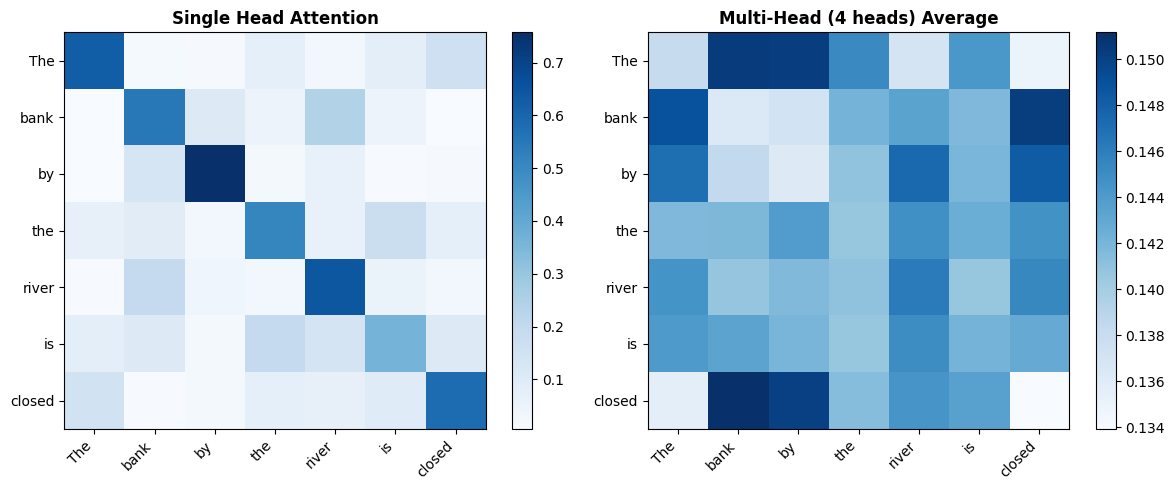


**Key Difference**: Multi-head attention captures richer relationships by combining 
diverse attention patterns, while single-head is limited to one perspective.


In [8]:
# Single head attention for comparison
_, single_weights = single_head_attention(X, X, X)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Single head
im1 = axes[0].imshow(single_weights, cmap='Blues', aspect='auto')
axes[0].set_xticks(range(len(tokens)))
axes[0].set_yticks(range(len(tokens)))
axes[0].set_xticklabels(tokens, rotation=45, ha='right')
axes[0].set_yticklabels(tokens)
axes[0].set_title("Single Head Attention", fontweight='bold')
plt.colorbar(im1, ax=axes[0])

# Multi-head average
im2 = axes[1].imshow(avg_weights, cmap='Blues', aspect='auto')
axes[1].set_xticks(range(len(tokens)))
axes[1].set_yticks(range(len(tokens)))
axes[1].set_xticklabels(tokens, rotation=45, ha='right')
axes[1].set_yticklabels(tokens)
axes[1].set_title(f"Multi-Head ({num_heads} heads) Average", fontweight='bold')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

md("""
**Key Difference**: Multi-head attention captures richer relationships by combining 
diverse attention patterns, while single-head is limited to one perspective.
""")

## 🎯 Summary

### Key Takeaways

1. **Multi-Head Attention** runs multiple attention mechanisms in parallel
2. Each head has its own **Q, K, V projections**, learning different patterns
3. Outputs are **concatenated** and projected back to the model dimension
4. Different heads may learn: positional patterns, syntactic relations, semantic similarity

### Real-World Insights

| Model | Heads | d_model | d_k per head |
|-------|-------|---------|-------------|
| GPT-2 Small | 12 | 768 | 64 |
| GPT-3 | 96 | 12288 | 128 |
| BERT-Base | 12 | 768 | 64 |

### Next Steps

- **mini-positional**: Understand how position information is added to embeddings